# Fingerprints Quality Classification
## DNN Course JCE - Final Project 
### By Kobi Amsellem & Zohar Kedem

Expirements:
* Try to classify 5 classes that represat the quality of the finger print (0 poor, 4 best)

In [1]:
# Relevenat includes
import numpy as np
import tensorflow as tf
from keras import layers, Sequential
from keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

**Hyperparameters**

In [2]:
batch_size = 32
img_height = 180
img_width = 180
validation_split = 0.3
seed=9

**Loading data to train and validation tensors**

Total:  976  examples
Found 976 files belonging to 5 classes.
Using 684 files for training.
Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2022-01-23 22:52:59.069607: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-23 22:52:59.070492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-23 22:52:59.070875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 976 files belonging to 5 classes.
Using 292 files for validation.


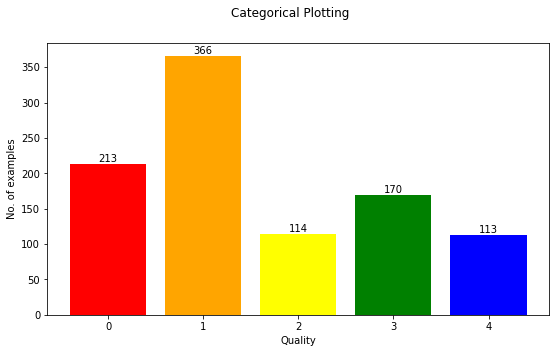

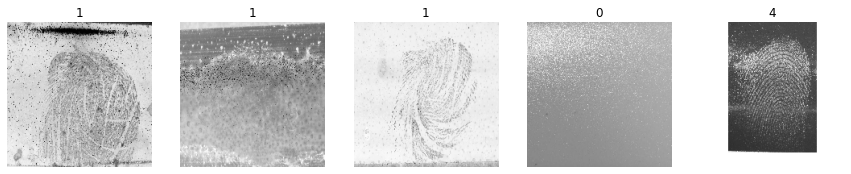

In [3]:
dirs = !ls Dataset

data_dir = pathlib.Path('./Dataset')
count = len(list(data_dir.glob('*/*.jpg')))
print('Total: ', count, ' examples')


counts = []
for dir in dirs:
  ddir = pathlib.Path('./Dataset/'+dir+'/')
  counts.append(len(list(ddir.glob('*.jpg'))))

fig, axs = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
c = ['red', 'orange', 'yellow', 'green', 'blue']
axs.bar(dirs, counts, color=c)
axs.set_ylabel('No. of examples')
axs.set_xlabel('Quality')
axs.bar_label(axs.containers[0])
fig.suptitle('Categorical Plotting')

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels='inferred',
  label_mode='categorical',
  )
train_ds = train_ds.prefetch(buffer_size=32)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels='inferred',
  label_mode='categorical',
  )
val_ds = val_ds.prefetch(buffer_size=32)

plt.figure(figsize=(15, 5))
for images, labels in train_ds.take(1):
  for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(np.argmax(labels[i].numpy()))
    plt.axis("off")

**Data Augmentation**
Set sequential data augmentation pipeline:

* Random Rotation
* Random Flip
* Random Contrast

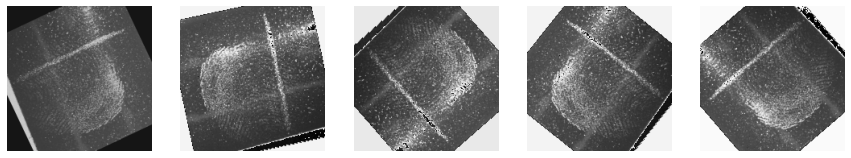

In [4]:
data_augmentation = Sequential()
data_augmentation.add(layers.RandomFlip(mode="horizontal_and_vertical", seed=seed))
data_augmentation.add(layers.RandomRotation((0,1),fill_mode="constant",interpolation="bilinear",seed=seed,fill_value=0.0))
data_augmentation.add(layers.RandomContrast(0.4, seed=None))

plt.figure(figsize=(15, 5))
with tf.device('/cpu:0'):
    for images, _ in train_ds.take(1):
        for i in range(5):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

In [5]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.EfficientNetB2(include_top=False,
# pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)


31801344/31790344 [==============================] - 6s 0us/step


In [6]:
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dropout(0.4))
resnet_model.add(layers.Dense(128, activation='relu'))
resnet_model.add(layers.Dropout(0.3))
resnet_model.add(layers.Dense(32, activation='relu'))
# resnet_model.add(layers.Dropout(0.2))
resnet_model.add(layers.Dense(5, activation='softmax'))

resnet_model.build((None, 180, 180, 3))
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 efficientnetb2 (Functional)  (None, 1408)             7768569   
                                                                 
 flatten (Flatten)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 512)               721408    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [7]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


/Users/kobiamsellem/tensorflow-metal/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-01-23 22:53:22.742743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 1.2833 - accuracy: 0.4810

2022-01-23 22:53:45.589364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 36s 711ms/step - loss: 1.2833 - accuracy: 0.4810 - val_loss: 1.1432 - val_accuracy: 0.5616
Epoch 2/10
22/22 [==============================] - 6s 252ms/step - loss: 1.0489 - accuracy: 0.5833 - val_loss: 0.9776 - val_accuracy: 0.6507
Epoch 3/10
22/22 [==============================] - 6s 250ms/step - loss: 1.0355 - accuracy: 0.5863 - val_loss: 0.9017 - val_accuracy: 0.7055
Epoch 4/10
22/22 [==============================] - 6s 251ms/step - loss: 0.9099 - accuracy: 0.6608 - val_loss: 0.8536 - val_accuracy: 0.7089
Epoch 5/10
22/22 [==============================] - 6s 250ms/step - loss: 0.8758 - accuracy: 0.6550 - val_loss: 0.8745 - val_accuracy: 0.6747
Epoch 6/10
22/22 [==============================] - 6s 250ms/step - loss: 0.8338 - accuracy: 0.6740 - val_loss: 0.8412 - val_accuracy: 0.6952
Epoch 7/10
22/22 [==============================] - 6s 263ms/step - loss: 0.8539 - accuracy: 0.6667 - val_loss: 0.8176 - val_accuracy: 0.7021
Epoch 8/10
22/22

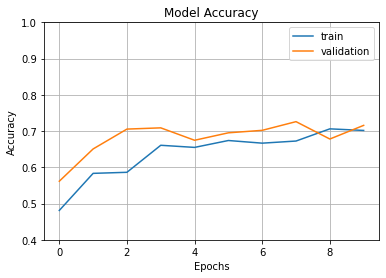

In [8]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()